In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer
import logging
logger=  logging.getLogger()
%load_ext autoreload

In [2]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
shipsize_data = pd.DataFrame({"shipsize": np.zeros(y_data.shape[0], dtype=np.int32)})
ship_size_mapping_data = pd.read_csv(os.path.realpath("data/shipsize_index.csv"), usecols=["shipsize"])
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]
    shipsize_data.at[x, "shipsize"] = ship_size_mapping_data.at[ship_data.at[x, "ship"]-1, "shipsize"]


In [3]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = y_data.shape[0]
shipsize_count = int(np.max(shipsize_data["shipsize"]))
print(engine_count, shipsize_count, ship_count, max_age, data_count)
print(engine_data.shape, shipsize_data.shape, ship_data.shape, age_data.shape, y_data.shape)

5 5 99 31 653
(653, 1) (653, 1) (653, 1) (653, 1) (653, 1)


# gaussian process model

In [4]:
#gp_model_dir = "gaussianprocess/models/hier_gp_weak/hier_gp_weak.stan"
gp_model_dir = "gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar


In [5]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [6]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


CPU times: user 1.1 s, sys: 88.7 ms, total: 1.19 s
Wall time: 1min 55s


In [7]:
gp_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-1-2_vwgd3k.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-2-dg03u2qm.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-3-kl5o6njy.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-4-tzpl27gq.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
3 of 4000 (0.075%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-1-2_vwgd3k.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-2-dg03u2qm.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-3-kl5o6njy.csv, /tmp/tmpu7_qssf0/trend_hp_engineVar-202009031345-4-tzpl27gq.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n3 of 4000 (0.075%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [8]:
gp_az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="obs_mu", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# spline model

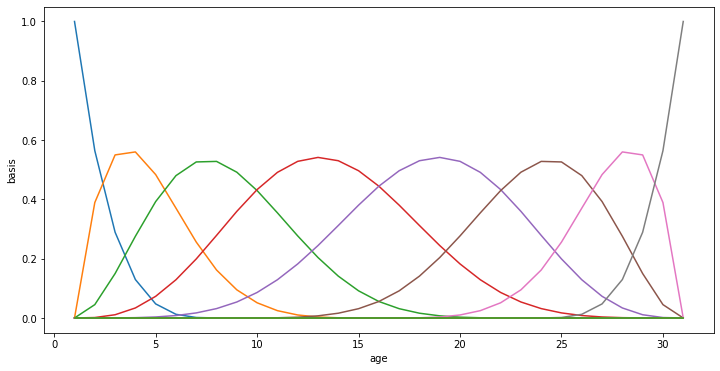

In [9]:
degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [10]:
basis_df.shape

(31, 13)

In [11]:
spline_model_file = os.path.join('spline/models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=spline_model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [12]:
data = {
    "K" : basis_df.shape[1],
    "N" : int(data_count),  # number of total values
    "T" : int(max_age),  # length of time of data(31)
    "S" : int(ship_count), #failure_df.shape[1],  # number of ships(99)
    "E" : int(engine_count),  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": int(data_count),
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [13]:
%%time
spline_model_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


CPU times: user 540 ms, sys: 54 ms, total: 594 ms
Wall time: 45.2 s


In [14]:
spline_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-1-q1rxovgx.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-2-wlmux8ss.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-3-c5koi_fo.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-4-yoy0d33c.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
176 of 4000 (4.4%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.1:
  log_lik[514], log_lik[555], log_lik[601], log_lik[647]
Such hig

"Processing csv files: /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-1-q1rxovgx.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-2-wlmux8ss.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-3-c5koi_fo.csv, /tmp/tmpu7_qssf0/layer3_nc_diffsd_parammubar-202009031347-4-yoy0d33c.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n176 of 4000 (4.4%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nThe following parameters had split R-hat greater than 1.1:\n  log_lik[514], log_lik[555], log_lik[601], log_lik[647]\nSuch

In [15]:
#pd.set_option('display.max_rows', None)
spline_model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-271.831000,0.452336,13.406400,-294.063000,-271.748000,-250.174000,878.42,11.0253,1.003560
mu_a_bar,-0.170514,0.010157,0.434286,-0.878669,-0.175256,0.532338,1828.34,22.9481,1.002300
mu_w_bar[1],-1.262760,0.009533,0.460587,-2.034170,-1.241500,-0.529537,2334.33,29.2990,1.002030
mu_w_bar[2],0.710281,0.009785,0.476583,-0.077323,0.714194,1.487610,2372.41,29.7769,1.002290
mu_w_bar[3],0.115304,0.012102,0.575669,-0.832623,0.115119,1.037880,2262.85,28.4018,1.003030
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],1.984110,0.013170,0.816090,0.649163,1.967430,3.327010,3839.96,48.1967,1.000600
y_new_pred[650],0.599685,0.013097,0.837694,-0.778816,0.607349,1.933500,4090.92,51.3466,1.000440
y_new_pred[651],0.784155,0.013463,0.848818,-0.641299,0.805258,2.165610,3975.30,49.8953,0.999284


In [16]:
np.mean(spline_model_fit.get_drawset(params=["s_a_bar"]), axis=0)

s_a_bar    0.421927
dtype: float64

In [17]:
spline_az_inference = az.from_cmdstanpy(spline_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# check out arviz stuff

In [18]:
gp_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [19]:
spline_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
az.loo(gp_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -740.27    18.27
p_loo      214.94        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      443   67.8%
 (0.5, 0.7]   (ok)        166   25.4%
   (0.7, 1]   (bad)        44    6.7%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [21]:
az.loo(spline_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -796.87    18.19
p_loo       80.72        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      646   98.9%
 (0.5, 0.7]   (ok)          6    0.9%
   (0.7, 1]   (bad)         1    0.2%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [22]:
%autoreload 2

In [23]:
logger.setLevel(logging.DEBUG)
comp = az.compare({"gaussian_process": gp_az_inference, "spline": spline_az_inference}, ic="loo", method="stacking")
comp

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 740.0800100260642
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 5


/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
gaussian_process,0,-740.274,214.942,0,0.952806,18.2662,0,True,log
spline,1,-796.875,80.7243,56.6007,0.0471938,18.1899,11.2218,True,log


In [24]:
spline_yhat = np.mean(spline_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values

In [25]:
gp_yhat = np.mean(gp_model_fit.get_drawset(params=["obs_mu"]), axis=0).values

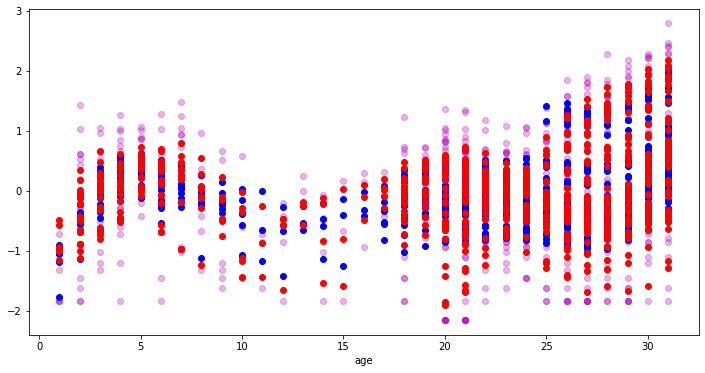

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)

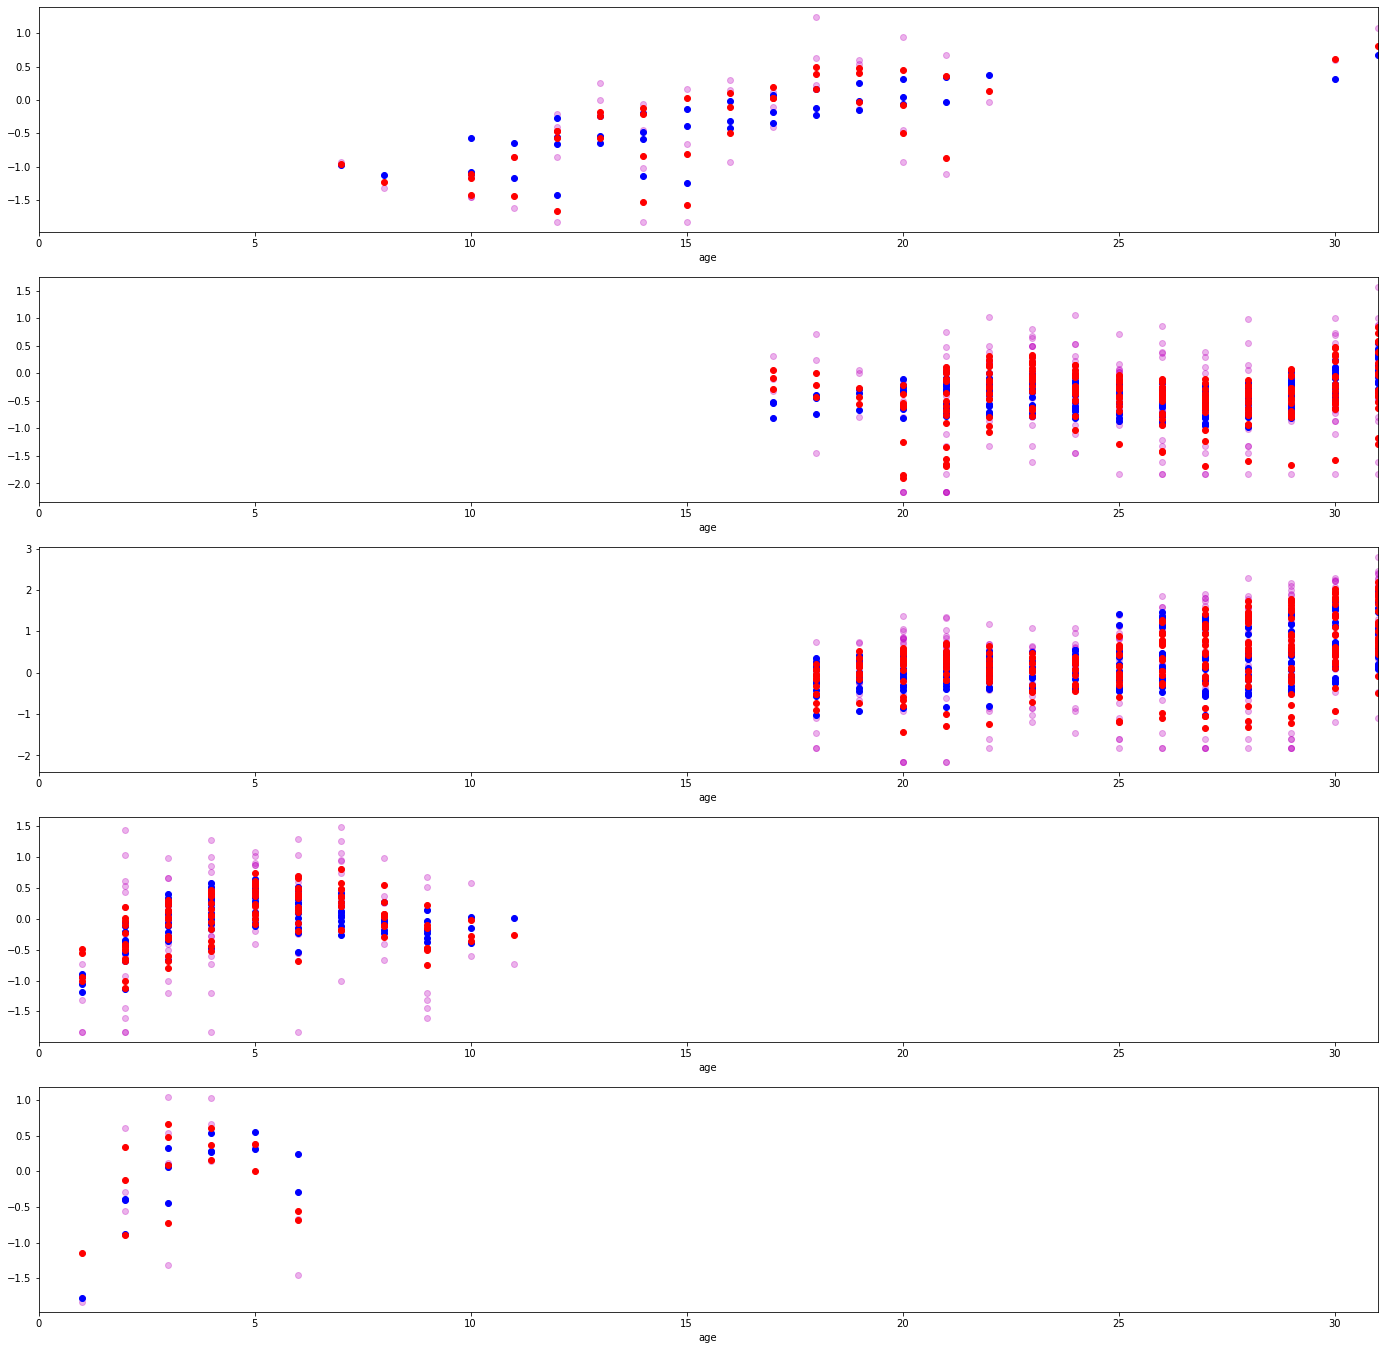

In [27]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")

In [28]:
mean_squared_error(y_data["y"].values, spline_yhat)

0.5106305309733075

In [29]:
mean_squared_error(y_data["y"].values, gp_yhat)

0.25669559232505496

# stack em up

In [30]:
stacked_yhat = np.dot(np.transpose(np.vstack([gp_yhat, spline_yhat])), comp.weight.values)

In [31]:
mean_squared_error(y_data["y"].values, stacked_yhat)

0.2637133127644638

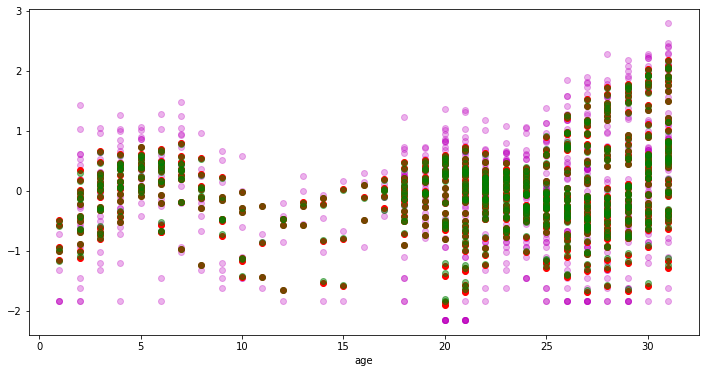

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
#ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)

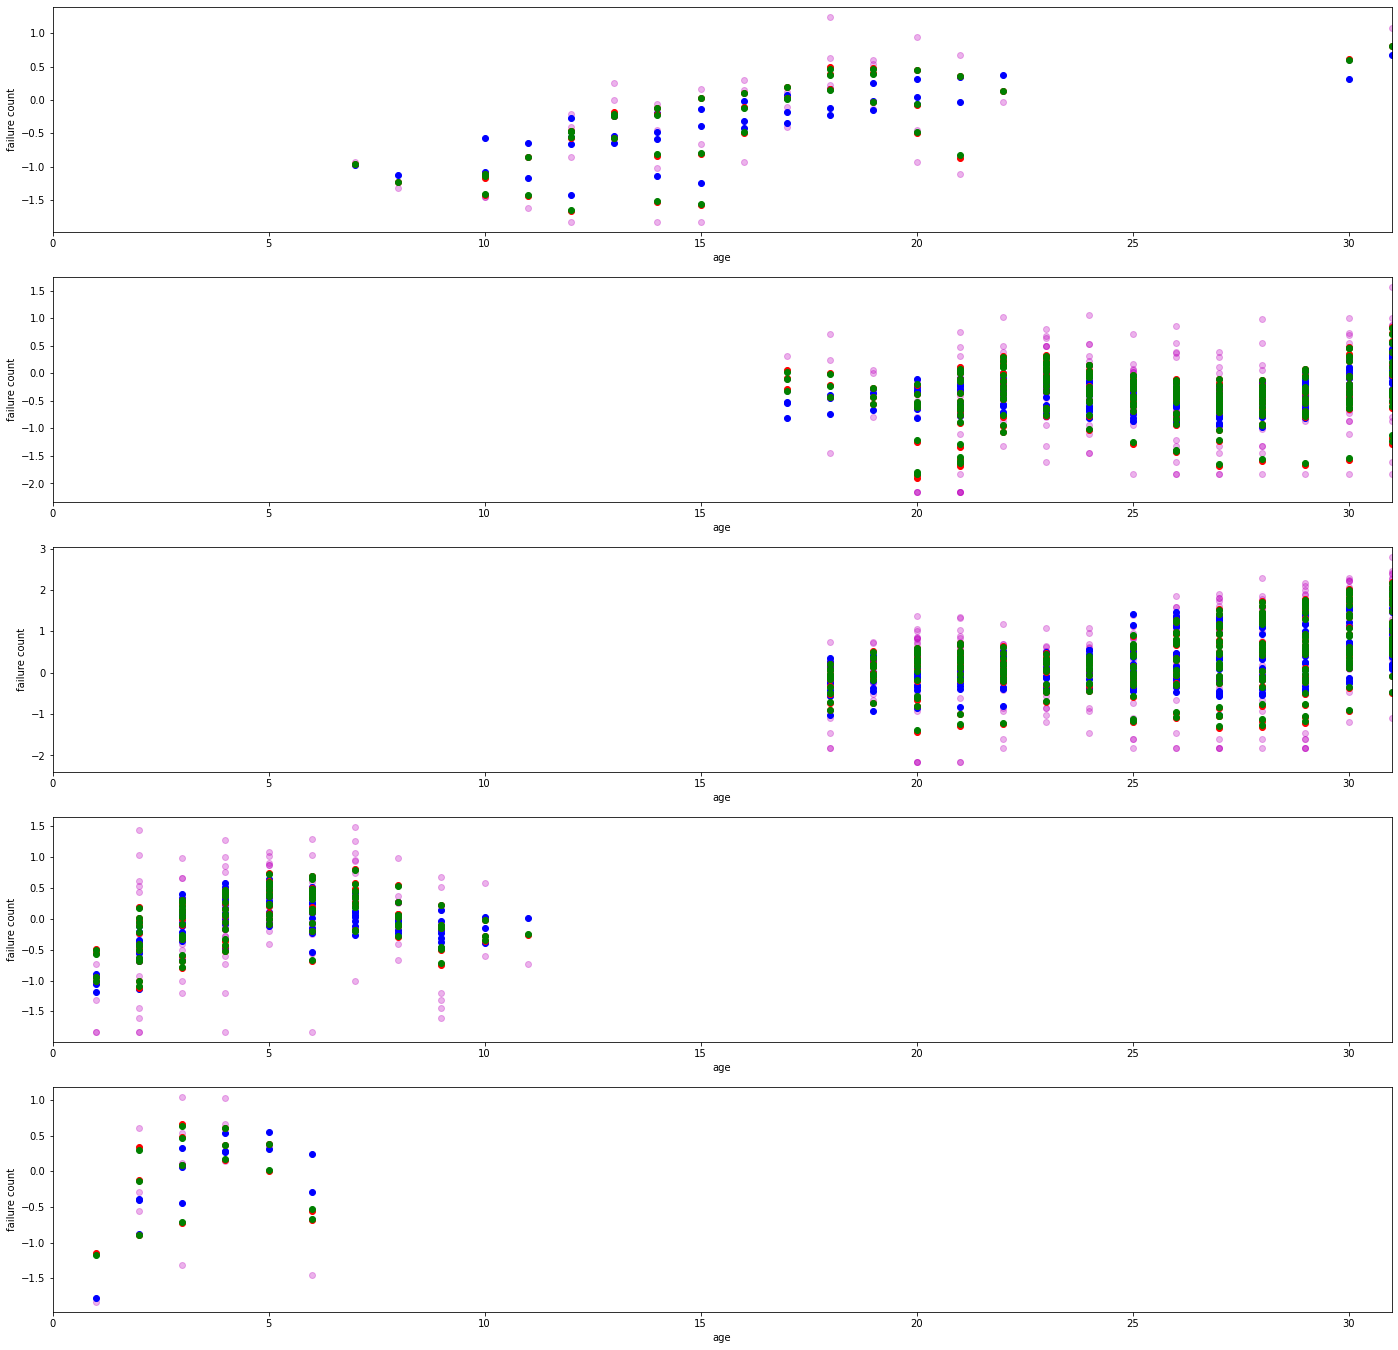

In [33]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_ylabel('failure count')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], stacked_yhat[engine_data["engine"].values == x], color="green")

## Yhat stacking

In [43]:
import numpy as np
import scipy.optimize
import scipy.stats
import pandas as pd
import arviz
from sklearn.metrics import mean_squared_error
class YhatWeightStacking:
    def __init__(self, yhat_dict, y):
        """
        Stacks multiple models by a linear combination of each model and weights, and minimizes the MSE
        values on weights.
        :param yhat_dict: dict where key is model name string, value is a np.array like yhat values of model
        :param y: np array of true y values
        """
        self.yhat_dict = yhat_dict
        self.yhat_arr = np.vstack(list(yhat_dict.values()))
        self.y = y

    def _create_bounds(self, len_ar):
        return [(0, 1)] * len_ar  # is a closed interval

    @staticmethod
    def _constraint_sum_wk(ar):
        # sum of array equals 1
        return np.sum(ar) - 1

    @staticmethod
    def _minimize_obj(weights, yhat_arr, y_arr):
        """
        :param yhat_arr: array of yhat values shape(model_count, data_length)
        :param y_arr: true y value array of shape(data_length)
        """
        mse = mean_squared_error(y_arr, np.dot(np.transpose(yhat_arr), weights))
        return mse

    def minimize(self):
        """
        Minimize MSE and return dict of stack weights for each model
        """

        constraint = {"type": "eq", "fun": YhatWeightStacking._constraint_sum_wk}
        bounds = self._create_bounds(len(self.yhat_dict.keys()))
        initial = np.full((len(self.yhat_dict.keys()), ), 1/len(self.yhat_dict.keys()))  # start with equal weights
        res = scipy.optimize.minimize(fun=YhatWeightStacking._minimize_obj, args=(self.yhat_arr, self.y), x0=initial, bounds=bounds, constraints=constraint, options={"disp":True})

        print(res)
        return dict(zip(list(self.yhat_dict.keys()), res.x))

In [45]:
yhat_minimizer = YhatWeightStacking(yhat_dict={"gaussian_process": gp_yhat, "spline": spline_yhat}, y=y_data["y"].values)
yhat_minimizer.minimize()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25669559232505496
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
     fun: 0.25669559232505496
     jac: array([-0.24832241, -0.10483472])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1., 0.])


{'gaussian_process': 1.0, 'spline': 0.0}

In [46]:
weights = np.arange(0.0, 1.0, 0.01)
weights2 = np.tile(np.float64(1), weights.shape[0])
weights2 -= weights
cweights = np.dstack([weights, weights2])[0]
mse = np.tile(np.float64(0), cweights.shape[0])
for x in range(0, cweights.shape[0]):
    mse[x] = mean_squared_error(y_data["y"].values, np.transpose(yhat_minimizer.yhat_arr) @ cweights[x])

In [47]:
mse

array([0.51063053, 0.50699775, 0.50338707, 0.49979847, 0.49623196,
       0.49268754, 0.48916521, 0.48566497, 0.48218682, 0.47873076,
       0.47529678, 0.4718849 , 0.46849511, 0.4651274 , 0.46178179,
       0.45845826, 0.45515683, 0.45187748, 0.44862023, 0.44538506,
       0.44217198, 0.43898099, 0.43581209, 0.43266528, 0.42954056,
       0.42643793, 0.42335739, 0.42029894, 0.41726258, 0.41424831,
       0.41125612, 0.40828603, 0.40533803, 0.40241211, 0.39950829,
       0.39662655, 0.3937669 , 0.39092935, 0.38811388, 0.3853205 ,
       0.38254921, 0.37980001, 0.3770729 , 0.37436788, 0.37168495,
       0.36902411, 0.36638536, 0.3637687 , 0.36117412, 0.35860164,
       0.35605125, 0.35352294, 0.35101673, 0.3485326 , 0.34607056,
       0.34363062, 0.34121276, 0.33881699, 0.33644331, 0.33409172,
       0.33176222, 0.32945481, 0.32716949, 0.32490626, 0.32266512,
       0.32044607, 0.31824911, 0.31607423, 0.31392145, 0.31179075,
       0.30968215, 0.30759563, 0.30553121, 0.30348887, 0.30146